In [1]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

/home/mohammed/anaconda3/envs/scib_metrics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [4]:
st = time.time()

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
output = 'pbmc.h5ad'
gdown.download(url, output, quiet=False)

In [7]:
adata = sc.read('pbmc.h5ad')
# adata = sc.pp.subsample(adata, fraction=None, n_obs=5000, random_state=0, copy=True)

In [8]:
adata.X = adata.layers["counts"].copy()

In [9]:
condition_key = 'batch'
target_conditions = ['10X']

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [10]:
removed_viallni = ['Villani']
adata_villani_removed = adata[~adata.obs.study.isin(removed_viallni)].copy()
conditions = adata_villani_removed.obs['batch'].unique().tolist()
print(adata_villani_removed.obs['batch'])
adata_villani_removed, conditions

index
AAACCTGCAGCGAACA-1-Oetjen_A                Oetjen_A
AAACCTGCATGTCCTC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGACTGC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGCTTCT-1-Oetjen_A                Oetjen_A
AAACCTGTCCCGACTT-1-Oetjen_A                Oetjen_A
                                          ...      
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCATCATTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTCGCTTG-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTGTCTCG-1-Sun_sample4_TC    Sun_sample4_TC
Name: batch, Length: 32484, dtype: category
Categories (9, object): ['10X', 'Freytag', 'Oetjen_A', 'Oetjen_P', ..., 'Sun_sample1_CS', 'Sun_sample2_KC', 'Sun_sample3_TB', 'Sun_sample4_TC']


(AnnData object with n_obs × n_vars = 32484 × 12303
     obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
     layers: 'counts',
 ['Oetjen_A',
  'Oetjen_P',
  'Oetjen_U',
  'Freytag',
  '10X',
  'Sun_sample1_CS',
  'Sun_sample2_KC',
  'Sun_sample3_TB',
  'Sun_sample4_TC'])

In [11]:
trvae_std = sca.models.TRVAE(
    adata=adata_villani_removed,
    condition_key=condition_key,
    conditions=conditions,
    hidden_layer_sizes=[128, 128],
 )


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 12303 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 12303 



In [12]:
trvae_std.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

 |█-------------------| 7.0%  - val_loss: 4344.9350585938 - val_recon_loss: 4292.9502140925 - val_kl_loss: 40.6948026510 - val_mmd_loss: 45.0666938195
ADJUSTED LR
 |██------------------| 11.2%  - val_loss: 4336.8727933444 - val_recon_loss: 4285.4362605168 - val_kl_loss: 40.9557773884 - val_mmd_loss: 40.1736994523
ADJUSTED LR
 |██------------------| 14.0%  - val_loss: 4345.4660081130 - val_recon_loss: 4291.1754056490 - val_kl_loss: 40.9599336477 - val_mmd_loss: 40.1594291100
ADJUSTED LR
 |███-----------------| 17.0%  - val_loss: 4356.8258338341 - val_recon_loss: 4300.2864896334 - val_kl_loss: 40.9594679612 - val_mmd_loss: 39.3363541823
ADJUSTED LR
 |███-----------------| 18.4%  - val_loss: 4359.6053654597 - val_recon_loss: 4300.5160851112 - val_kl_loss: 40.9595614213 - val_mmd_loss: 40.4526472092
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best s

In [13]:
adata_villani_removed_latent = sc.AnnData(trvae_std.get_latent())
adata_villani_removed_latent.obs['cell_type'] = adata_villani_removed.obs["final_annotation"].tolist()
adata_villani_removed_latent.obs['batch'] = adata_villani_removed.obs["batch"].tolist()

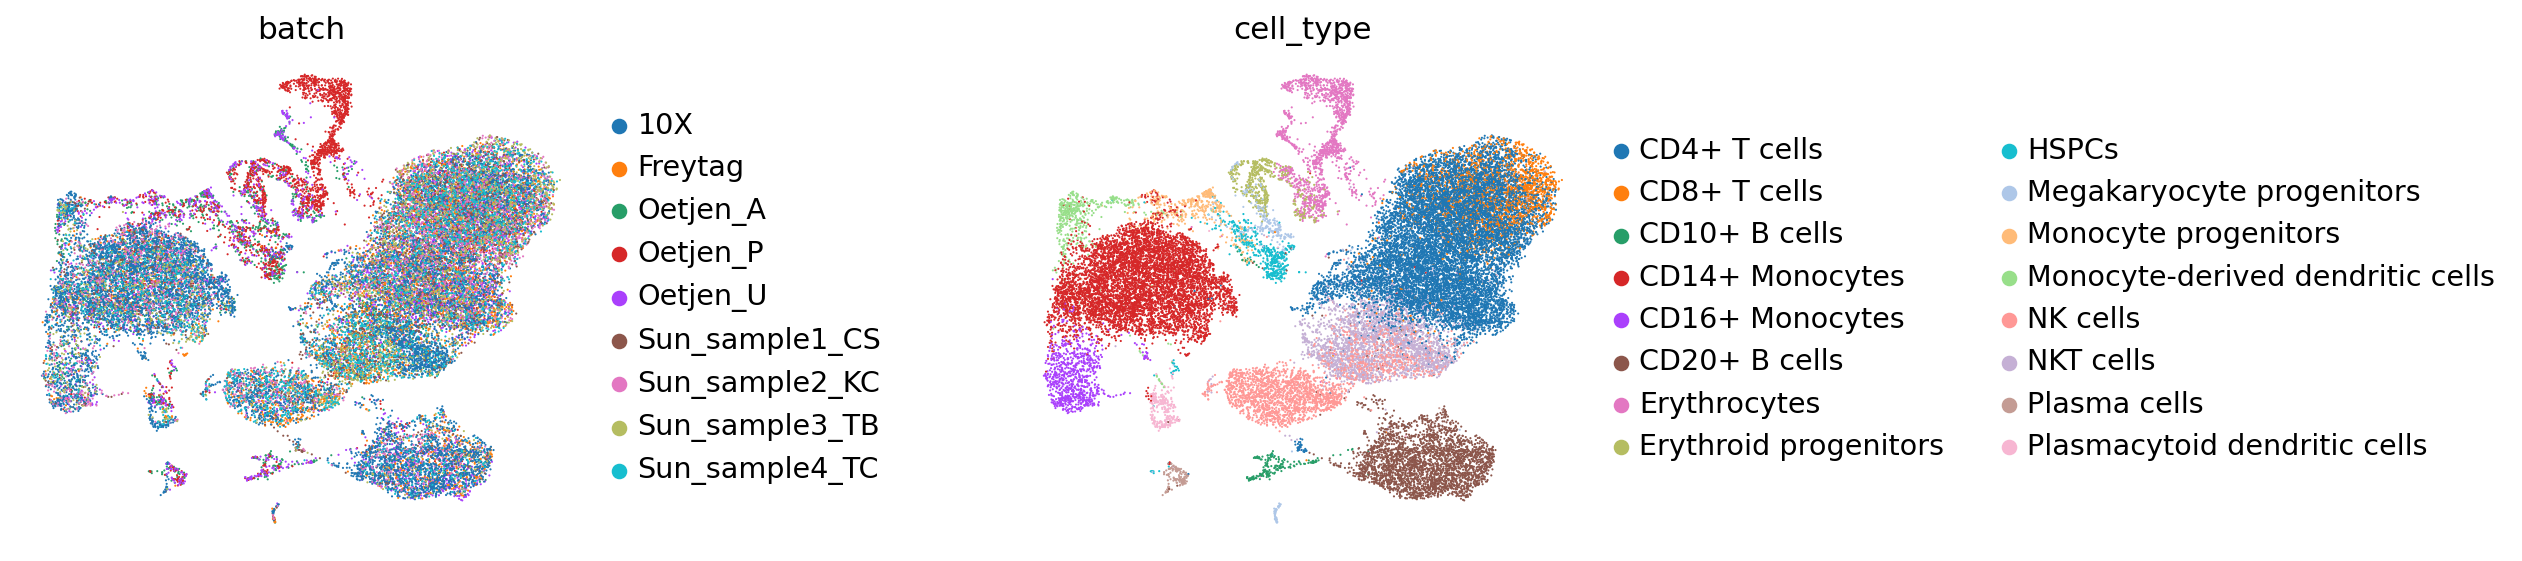

In [14]:
sc.pp.neighbors(adata_villani_removed_latent, n_neighbors=8)
sc.tl.leiden(adata_villani_removed_latent)
sc.tl.umap(adata_villani_removed_latent)
sc.pl.umap(adata_villani_removed_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [16]:
X_std = trvae_std.get_latent(adata_villani_removed.X, adata_villani_removed.obs[condition_key])
%store X_std

Stored 'X_std' (ndarray)


In [17]:
ref_path = 'reference_model_PBMC/'
trvae_std.save(ref_path, overwrite=True)

In [18]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 17:09:59


In [19]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(adata_villani_removed_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_std=scib.metrics.graph_connectivity(adata_villani_removed_latent, 'batch')

Batch_corr_graph_conn_std

0.3397012752767046

In [20]:
sc.tl.umap(adata_villani_removed_latent)
Batch_corr_ASW_std=scib.metrics.silhouette_batch(adata_villani_removed_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_std


/tmp/ipykernel_116/750901708.py:2: DeprecationWarning: Keyword argument 'group_key' has been deprecated in favour of 'label_key'. 'group_key' will be removed in a future version.
  Batch_corr_ASW_std=scib.metrics.silhouette_batch(adata_villani_removed_latent, batch_key='batch', group_key='cell_type', embed='X_umap')


mean silhouette per group:                                   silhouette_score
group                                             
CD10+ B cells                             0.726950
CD14+ Monocytes                           0.905825
CD16+ Monocytes                           0.768702
CD20+ B cells                             0.769449
CD4+ T cells                              0.727261
CD8+ T cells                              0.796478
Erythrocytes                              0.793006
Erythroid progenitors                     0.885450
HSPCs                                     0.643662
Megakaryocyte progenitors                 0.734966
Monocyte progenitors                      0.857188
Monocyte-derived dendritic cells          0.697423
NK cells                                  0.705336
NKT cells                                 0.780029
Plasma cells                              0.656852
Plasmacytoid dendritic cells              0.766598


0.763448411619085

In [21]:
Bio_cons_ASW_std=scib.metrics.silhouette(adata_villani_removed_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_std

/tmp/ipykernel_116/2516140492.py:1: DeprecationWarning: Keyword argument 'group_key' has been deprecated in favour of 'label_key'. 'group_key' will be removed in a future version.
  Bio_cons_ASW_std=scib.metrics.silhouette(adata_villani_removed_latent, group_key='cell_type', embed='X_umap')


0.5762711763381958

In [22]:
isolated_labels_std=scib.metrics.isolated_labels(adata_villani_removed_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_std

isolated labels: no more than 3 batches per label
Compute neighbors on rep X_umap
CD10+ B cells: 0.9296482412060302
Compute neighbors on rep X_umap
Erythrocytes: 0.6977479257210589
Compute neighbors on rep X_umap
Erythroid progenitors: 0.7995824634655533
Compute neighbors on rep X_umap
Monocyte progenitors: 0.6130500758725341


0.7600071765662941